In [43]:
import time
begin=time.time()
import torch 
import torch.nn as nn
import imageio
from imageio import imread
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import numpy as np

torch.Size([407, 407, 3])


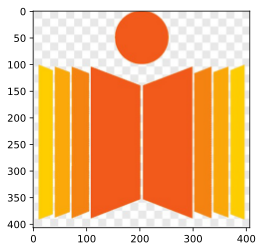

In [44]:
logo = imageio.imread('iith logo.jpeg')
logo = torch.from_numpy(logo)
print(logo.size())
plt.imshow(logo)

#https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FIIT_Hyderabad&psig=AOvVaw2H7Q7eOMsow3Xx_A3qZPaD&ust=1677559778477000&source=images&cd=vfe&ved=0CA8QjRxqFwoTCLjD8abztP0CFQAAAAAdAAAAABAE

In [45]:
Sigmoid = lambda Z : 1/(1+torch.exp(-Z))
ReLU = lambda Z : torch.maximum(Z,torch.zeros_like(Z))
Tanh = lambda Z : (torch.exp(Z) - torch.exp(-Z))/(torch.exp(Z) + torch.exp(-Z))
PReLU = lambda Z : torch.maximum(torch.zeros_like(Z),Z) + (0.25)*torch.minimum(torch.zeros_like(Z),Z)

In [46]:
min_pooling = lambda Z : torch.min(Z)
max_pooling = lambda Z : torch.max(Z)
avg_pooling = lambda Z : torch.sum(Z)/(Z.size(0))

In [47]:
#accepts kernel dimensions

#it returns the mutlichannel image
def convolution_layer_function(image,filters,kernel_dimensions,stride,padding,activation):
    pad = torch.nn.ZeroPad2d(padding)
    newimage = image.permute(2,0,1)
    newimage = pad(newimage)
    halfkernel = (kernel_dimensions[0])//2
    width = (newimage.size(1)-stride[0]+2*padding[1])//stride[0] + 1
    height = (newimage.size(2)-stride[1]+2*padding[2])//stride[1] + 1
    convoutput = torch.zeros(filters,width,height)
    kernel = (torch.rand(filters,kernel_dimensions[0],kernel_dimensions[1],image.size(2))-0.5)*10
    
    #convolution---------------------------------------------------------------------------------
    for f in range(filters):
        for i in range(newimage.size(0)):
            for row in range(halfkernel,newimage.size(1)-halfkernel,stride[0]):
                for col in range(halfkernel,newimage.size(2)-halfkernel,stride[1]):
                    img = newimage[i,row-halfkernel:row+halfkernel+1,:]
                    img = img[:,col-halfkernel:col+halfkernel+1]
                    a = (row-halfkernel)//stride[0]
                    b = (col-halfkernel)//stride[1]
                    convolve =  torch.sum(torch.mul(img,kernel[f,:,:,i]))
                    convoutput[f,a,b] = convoutput[f,a,b] + convolve
    #---------------------------------------------------------------------------------------------
                    
#activation(convoutput) - tensor after passing the convoutput to the required the activation function 
#.permute is used to change the seprated channels into the image

    return activation(convoutput)
    

In [48]:
#resimage is the output of the image after convolution
resimage = convolution_layer_function(logo,4,(3,3),(3,3),(3,3,3,3),ReLU)

In [49]:
resimage.size()

torch.Size([4, 139, 139])

(4,)


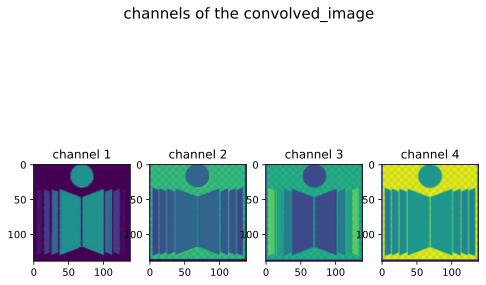

In [50]:
fig,ax =plt.subplots(1,4,figsize=(8,6))
fig.suptitle('channels of the convolved_image',fontsize=15)
j = 0
print(ax.shape)
for i in range(4):
    ax[j].imshow(resimage[i,:,:])
    ax[j].set_title('channel {0}'.format(i+1))
    j = j+1

Text(0.5, 1.0, 'convolved image')

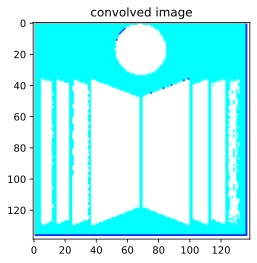

In [51]:
plt.imshow(resimage.permute(1,2,0))
plt.title('convolved image')

In [52]:
def pooling_layer_function(input_activation,function,stride = None):
    if function == 'global_avg_pooling' :
        newimage =  torch.zeros(input_activation.size(0),1,1)
        for i in range(input_activation.size(0)):
            newimage[i,0,0] = avg_pooling(input_activation[i,:,:])
        return newimage
    width = (input_activation.size(1)-stride)//stride + 1
    height = (input_activation.size(2)-stride)//stride + 1
    newimage = torch.zeros(input_activation.size(0),width,height)
    halfkernel = stride//2
    
    #pooling------------------------------------------------------------------------
    for f in range(input_activation.size(0)):
        for row in range(halfkernel,input_activation.size(1)-halfkernel,stride):
            for col in range(halfkernel,input_activation.size(2)-halfkernel,stride):
                img = input_activation[f,row-halfkernel:row+halfkernel+1,:]
                img = img[:,col-halfkernel:col+halfkernel+1]
                a = (row-halfkernel)//stride
                b = (col-halfkernel)//stride
                newimage[f,a,b] = function(img)
    #--------------------------------------------------------------------------------
    
    return newimage

In [53]:
pooled_image = pooling_layer_function(resimage,max_pooling,3)#pooled_image is the output of the convolved image after pooling

In [54]:
print(pooled_image.size())#we can see that the size matches of that required after passing through pooling function

torch.Size([4, 46, 46])


Text(0.5, 1.0, 'channel 4')

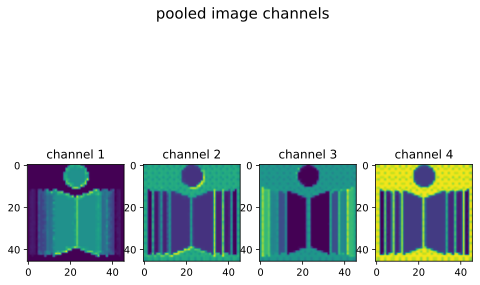

In [55]:
#plotting -------------------------------------------
fig,ax =plt.subplots(1,4,figsize=(8,6))
fig.suptitle('pooled image channels',fontsize=15)
ax[0].imshow(pooled_image[0,:,:])
ax[0].set_title('channel 1')

ax[1].imshow(pooled_image[1,:,:])
ax[1].set_title('channel 2')

ax[2].imshow(pooled_image[2,:,:])
ax[2].set_title('channel 3')

ax[3].imshow(pooled_image[3,:,:])
ax[3].set_title('channel 4')

Text(0.5, 1.0, 'pooled image')

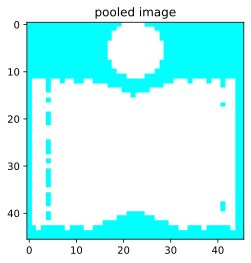

In [56]:
plt.imshow(pooled_image.permute(1,2,0))
plt.title('pooled image')